In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import timeit

In [2]:
VFILE = "../data/contest-example.mp4"
VFILE1 = "../data/long-video.mp4"
VFILE2 = "../data/sample-video.mp4"

In [3]:
# get the video 
def get_frames(filename):
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame
        else:
            break
    video.release()
    yield None

In [26]:
# play the whole video
for f in get_frames(VFILE):
    if f is None: 
        break
    cv2.imshow('frame', f)
    if cv2.waitKey(30) == 27:
        break
cv2.destroyAllWindows()

In [4]:
# get specific frame 
def get_frame(filename, index):
    counter = 0
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            if counter == index:
                return frame
            counter += 1
        else: 
            break
    video.release()
    return None

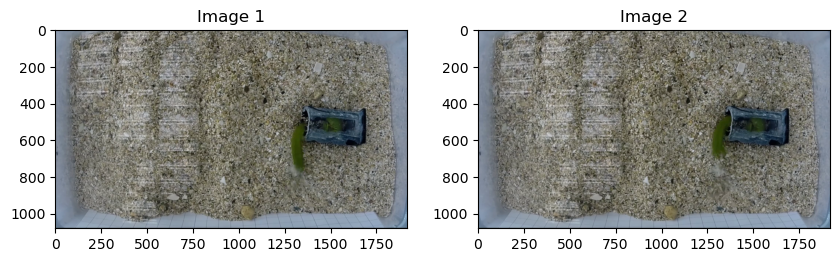

In [35]:
# get two sequential frames
i = 34
frame = get_frame(VFILE, i)
frame1 = get_frame(VFILE, i+1)
fix_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fix_frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].imshow(fix_frame, cmap = "gray")
axs[0].set_title('Image 1')
axs[1].imshow(fix_frame1, cmap = "gray")
axs[1].set_title('Image 2')
plt.show()

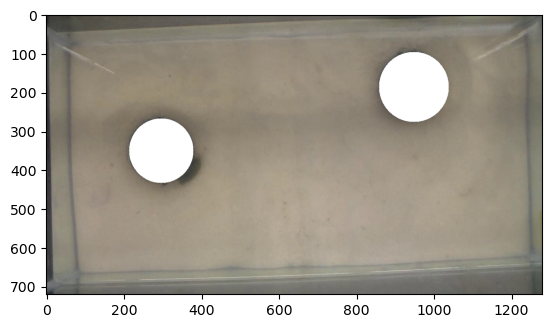

In [6]:
frame1 = get_frame(VFILE2, 1)
image = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame_neg = -1 * image + 255
new_image = cv2.convertScaleAbs(frame_neg, alpha = 3.0, beta = -400)
circles = cv2.HoughCircles(
    new_image,
    method = cv2.HOUGH_GRADIENT,
    dp = 2,
    minDist = 200,
    param1 = 150,
    param2 = 150,
    minRadius = 50,
    maxRadius = 100)
frame_copy = frame1.copy()
for x,y,r in circles[0]:
    cv2.circle(
        frame_copy,
        (int(x),int(y)),
        int(r),
        (255,255,255),
        thickness = -1)
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))

In [50]:
particles = np.random.rand(20, 4)
particles[:, 0:2]
np.var(particles[:,0:2])

0.08904063308294245

In [7]:
def initialize_particles(num_particles, top_left, bottom_right, width, height, vel_range):
    particles = np.random.rand(num_particles, 4)
    particles = particles * np.array((width, height, vel_range, vel_range))
    particles[:,2:4] -= vel_range/2.0 # shift the velocity down so everything has zero mean
    particles[:,0] += top_left[0] # shift the particles to the box by adding width
    particles[:,1] += top_left[1] # shift the particles to the box by adding height
    # E(uniform(0,1) * vel_range - vel_range/2.0) = 0
    return particles

In [8]:
def apply_velocity(particles):
    # apply velocity to particles
    particles[:,0] += particles[:,2]
    particles[:,1] += particles[:,3]
    return particles

In [9]:
def enforce_edges(particles, top_left, bottom_right):
    for i in range(len(particles)):
        particles[i,0] = max(top_left[0], min(bottom_right[0]-1, particles[i,0]))
        particles[i,1] = max(top_left[1], min(bottom_right[1]-1, particles[i,1]))
    return particles

In [18]:
def compute_errors(particles, frame, target):
    errors = np.zeros(len(particles))
    for i in range(len(particles)):
        x = int(particles[i,0])
        y = int(particles[i,1])
        pixel_value = frame[y,x,:]
        errors[i] = np.sum((target-pixel_value)**2)
    min_val = np.min(errors)
    mask = errors < 250
    errors[mask] = min_val
    return errors

In [11]:
def compute_weights(errors, particles, top_left, bottom_right):
    weights = np.max(errors) - errors
    weights = weights ** 2
    weights [
        (particles[:,0] == top_left[0]) |
        (particles[:,0] == bottom_right[0] - 1) |
        (particles[:,1] == top_left[1]) |
        (particles[:,1] == bottom_right[1] - 1) 
    ] = 0.0
    return weights

In [12]:
def resample(particles, weights):
    probabilities = weights/np.sum(weights)
    index_numbers = np.random.choice(
        len(particles),
        size  = len(particles),
        p = probabilities)
    particles = particles[index_numbers,:]
    x1 = np.mean(particles[:,0])
    y1 = np.mean(particles[:,1])
    var = np.var(particles[:,0:2])
    
    return particles, np.array([(int(x1), int(y1))]), np.array([var])
    

In [13]:
def apply_noise(particles, pos_sigma, vel_sigma):
    noise = np.concatenate(
    (
        np.random.normal(0.0, pos_sigma, (len(particles),1)),
        np.random.normal(0.0, pos_sigma, (len(particles),1)),
        np.random.normal(0.0, vel_sigma, (len(particles),1)),
        np.random.normal(0.0, vel_sigma, (len(particles),1)),
    ), axis = 1)
    particles += noise
    return particles

In [14]:
def display(frame, particles, top_left, bottom_right):
    for i in range(len(particles)):
        x = int(particles[i,0])
        y = int(particles[i,1])
        cv2.circle(frame, (x,y), 1, (255,0,0), 1)
    cv2.rectangle(frame, top_left, bottom_right, (255,255,255), 1)
#     cv2.imshow('frame', frame)
#     cv2.waitKey(30)
#     cv2.destroyAllWindows()

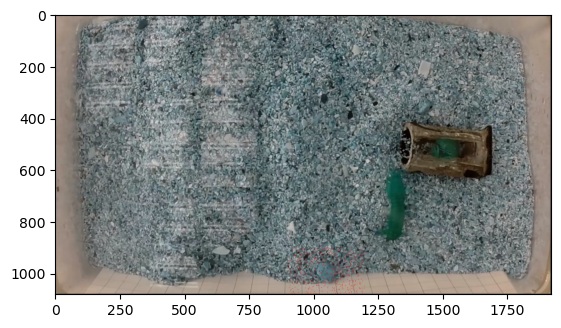

In [25]:
plt.imshow(frame)

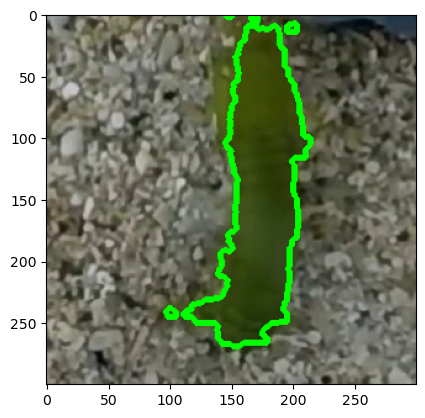

In [74]:
# cropped = frame[600:900, 1150:1450]
cropped = frame[400:700, 1300:1600]
converted = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(converted)

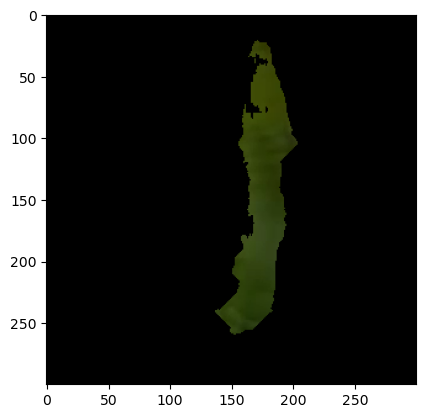

In [78]:
# threshold the color
converted_new = converted.copy()
color_filtered1 = (converted[:,:,0]<65) & (converted[:,:,1]<85) & (converted[:,:,2]<35)
converted_new[:, :, 0] = converted_new[:, :, 0] * color_filtered1
converted_new[:, :, 1] = converted_new[:, :, 1] * color_filtered1
converted_new[:, :, 2] = converted_new[:, :, 2] * color_filtered1
plt.imshow(converted_new)

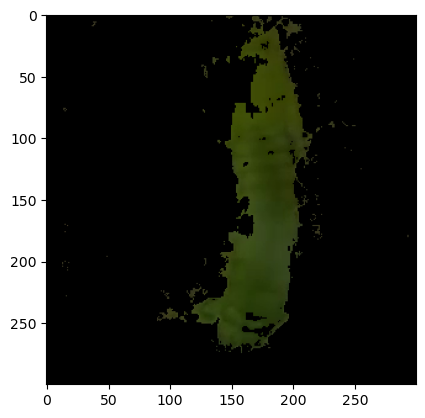

In [55]:
color_filtered2 = (35<converted[:,:,0]) & (50<converted[:,:,1]) & (0<converted[:,:,2])
converted_new[:, :, 0] = converted_new[:, :, 0] * color_filtered2
converted_new[:, :, 1] = converted_new[:, :, 1] * color_filtered2
converted_new[:, :, 2] = converted_new[:, :, 2] * color_filtered2
plt.imshow(converted_new)

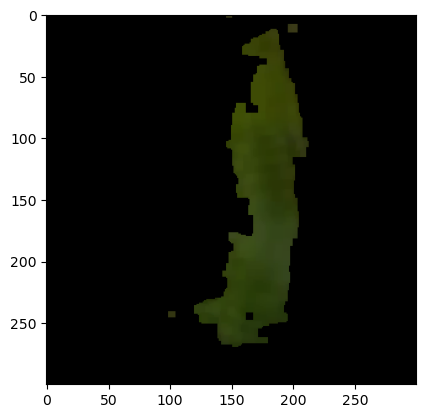

In [56]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
result = cv2.morphologyEx(converted_new, cv2.MORPH_OPEN, kernel)
result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
plt.imshow(result)

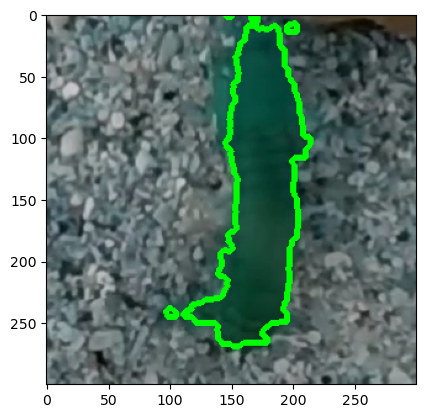

In [53]:
# draw contours on thresholded results
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 30, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(cropped, contours, -1, (0, 255, 0), 3)
plt.imshow(cropped)

In [166]:
particles = apply_velocity(particles)
display(frame, particles, top_left, bottom_right)
cv2.imshow('frame', frame)
cv2.waitKey(0)

27

In [167]:
particles = enforce_edges(particles, top_left, bottom_right)
display(frame, particles, top_left, bottom_right)

In [168]:
errors = compute_errors(particles, frame, target)
errors

array([376., 294., 250., 282., 473., 292., 691., 390., 357., 454., 402.,
       342., 396., 161., 164.,  25., 539., 411., 196., 393., 438., 281.,
        25., 345., 385., 268.,  25., 238., 394.,  25., 317.,  25., 374.,
       370., 486.,  25., 253., 349., 244., 274., 428., 211., 342., 408.,
       402., 337., 281., 330.,  25., 209., 546., 482., 298.,  25., 201.,
       422., 217., 154., 241., 162., 454., 232., 232., 233.,  25., 530.,
       582.,  25., 499., 329., 298., 364., 337.,  25., 306., 205., 232.,
       462.,  25.,  25., 504., 330., 194., 349., 459., 374., 202., 269.,
       202., 251., 394., 374., 286., 470., 169.,  25., 390., 315., 340.,
        25.])

In [169]:
weights = compute_weights(errors, particles)
weights

array([ 99225., 157609., 194481., 167281.,  47524., 159201.,      0.,
        90601., 111556.,  56169.,  83521., 121801.,  87025., 280900.,
       277729., 443556.,  23104.,  78400., 245025.,  88804.,  64009.,
       168100., 443556., 119716.,  93636., 178929., 443556., 205209.,
        88209., 443556., 139876., 443556., 100489., 103041.,  42025.,
       443556., 191844., 116964., 199809., 173889.,  69169., 230400.,
       121801.,  80089.,  83521., 125316., 168100., 130321., 443556.,
       232324.,  21025.,  43681., 154449., 443556., 240100.,  72361.,
       224676., 288369., 202500., 279841.,  56169., 210681., 210681.,
       209764., 443556.,  25921.,  11881., 443556.,  36864., 131044.,
       154449., 106929., 125316., 443556., 148225., 236196., 210681.,
        52441., 443556., 443556.,  34969., 130321., 247009., 116964.,
        53824., 100489., 239121., 178084., 239121., 193600.,  88209.,
       100489., 164025.,  48841., 272484., 443556.,  90601., 141376.,
       123201., 4435

In [170]:
particles, center, var = resample(particles, weights)

In [171]:
display(frame.copy(), particles, top_left, bottom_right)

In [15]:
pos_sigma = 1
vel_sigma = 1
particles = apply_noise(particles, pos_sigma, vel_sigma)
display(frame.copy(), particles, top_left, bottom_right)

NameError: name 'particles' is not defined

In [133]:
frame = get_frame(VFILE, 20)
num_particles = 200
top_left = (1150, 600)
bottom_right = (1450, 900)
width = 300
height = 300
vel_range = 1
pos_sigma = 1
vel_sigma = 1
target = np.array([16.5,65.,48. ], dtype=np.uint8)
particles = initialize_particles(num_particles, top_left, bottom_right, width, height, vel_range)

In [134]:
centers = np.array([(0,0)])
variance = np.array([0])
for i in range(50):
    frame1 = frame.copy()
    particles = apply_velocity(particles)
    particles = enforce_edges(particles,top_left, bottom_right)
    errors = compute_errors(particles, frame1, target)
    weights = compute_weights(errors, particles, top_left, bottom_right)
    particles, center, var = resample(particles, weights)
    centers = np.concatenate((centers, center), axis = 0)
    variance = np.concatenate((variance, var), axis = 0)
    particles = apply_noise(particles, pos_sigma, vel_sigma)
    display(frame1, particles, top_left, bottom_right)
    cv2.imshow("frame", frame1)
    if cv2.waitKey(0) == 27:
        break
cv2.destroyAllWindows()

In [128]:
np.median(centers, axis = 0).astype(np.uint8)

array([150, 103], dtype=uint8)

In [101]:
ini_sposition = []
ini_bposition = []
ini_color = []
def mouseInfo(event, x, y, flags, param):
    global ini_sposition, ini_bposition
    if event == cv2.EVENT_LBUTTONDOWN:
        ini_color.append(frame[y,x])
        ini_sposition.append((x,y))
        cv2.circle(frame, (x,y), 3, (255,255,255), 1)
        cv2.imshow("shrimp", frame)
    if event == cv2.EVENT_RBUTTONDOWN:
        ini_bposition.append((x,y))
        cv2.circle(frame, (x,y), 1, (0,0,255), -1)
        cv2.imshow("shrimp", frame)

In [102]:
counter = 0
for frame in get_frames(VFILE):
    if frame is None:
        break
    ini_sposition = []
    ini_bposition = []
    cv2.imshow('shrimp', frame) # set window name as "shrimp"
    cv2.setMouseCallback('shrimp', mouseInfo) # let Opencv listen to any event happened on window "shrimp"
    k = cv2.waitKey(0) # wait infinite time to proceed to the next frame until we press a key
    if k == 27:
        break # exist the window if the key is "esc"(27)
    counter += 1
cv2.destroyAllWindows()
ini_frame = counter
print(ini_sposition)  
print(ini_bposition)
print(ini_frame)
print(ini_color)


[(1324, 690), (1529, 508)]
[]
0
[array([ 7, 73, 53], dtype=uint8), array([27, 60, 42], dtype=uint8)]


In [137]:
start = timeit.default_timer()
counter = 0
pcenter = []
traj = []
# define video writer
size = (int(960), int(540))
writer = cv2.VideoWriter('final-demo.mp4', 
                         -1,
                         10, size)
# define the number of initial particles and their velocity range
num_particles = 200
vel_range = 1
pos_sigma = 1
vel_sigma = 1
width = 150
height = 150

for frame in get_frames(VFILE):
    if frame is None: 
        break
    if counter < ini_frame:
        counter += 1
        continue
    elif counter == ini_frame: 
        # select templates on the initial shrimp positions
        templates = []
        colors = np.array([[0,0,0]])
        for i in range(len(ini_sposition)):
            x_ini = ini_sposition[i][0] - 8
            y_ini = ini_sposition[i][1] - 8
            x_end = x_ini + 16
            y_end = y_ini + 16
            # creates templates for correlation calculation in the next frame
            template = frame[y_ini:y_end, x_ini:x_end]
            templates.append(template) 
            B = np.average(template[:,:,0])
            G = np.average(template[:,:,1])
            R = np.average(template[:,:,2])
            color = np.array([[B,G,R]], dtype = np.uint8)
            colors = np.concatenate((colors, color), axis = 0)
        w, h = templates[0].shape[0], templates[0].shape[1]
        colors = np.delete(colors, 0, axis = 0)
        target_color = np.average(colors, axis = 0)
        print(target_color)
        counter += 1
        continue
    else:
#         for x,y,r in circles[0]:
#             cv2.circle(
#                 frame,
#                 (int(x),int(y)),
#                 int(r),
#                 (255,255,255),
#                 thickness = -1)
        # resize to reduce the run time
        frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
        # create blank frame to add on correlation results
        result = np.full((frame.shape[0] - 15, frame.shape[1] - 15), 0).astype(np.float64)
        # threshold each template matching result
        for i in templates:
            corr = cv2.matchTemplate(frame, i, 3)
            corr[corr < 0.98] = 0
            corr[corr != 0] = 255
            result += corr
        # fill up all the holes in the correlation results using morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
        result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
        # save all the row and col indices of non zero correlation results
        row_indices, col_indices = np.nonzero(result)
        Z = np.hstack((row_indices.reshape(len(row_indices),1), col_indices.reshape(len(col_indices),1)))
        # convert to np.float32
        Z = np.float32(Z)
        # define criteria and apply kmeans()
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(Z, len(ini_sposition), None,criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center1 = ((center[0][1]+8).astype(np.int64),(center[0][0]+8).astype(np.int64))
        center2 = ((center[1][1]+8).astype(np.int64),(center[1][0]+8).astype(np.int64))
        # calculate the distance between two centers
        distance = math.sqrt((center2[0] - center1[0]) ** 2 + (center2[1] - center1[1]) ** 2)
        # if the distance is too low, which means two centers locate on one shrimp
        # this usually means either the shrimp is occluded, in the burrow, or lose track.
        if distance <= 50:
            # calculate the new center of the shrimp that has two centers
            new_center1 = (((center1[0] + center2[0])/2).astype(np.int64), ((center1[1] + center2[1])/2).astype(np.int64))
            frame = cv2.circle(frame, new_center1, radius=5, color=(0,0,255), thickness=-1)
            # calcuslate the distance between the new center and the old two centers
            new_dist1 = math.sqrt((new_center1[0] - pcenter[0][0]) ** 2 + (new_center1[1] - pcenter[0][1]) ** 2)
            new_dist2 = math.sqrt((new_center1[0] - pcenter[1][0]) ** 2 + (new_center1[1] - pcenter[1][1]) ** 2)
            # the new center of the other shrimp, new_center2, should be the one that has greater distance to new_center1
            if new_dist1 <= new_dist2:
                new_center2 = pcenter[1]
                pcenter = [new_center1, new_center2]
            else:
                new_center2 = pcenter[0]
                pcenter = [new_center2, new_center1]
            cv2.circle(frame, new_center2, radius=5, color=(0,0,255), thickness=-1)
        # if both shrimps do not lose track, assign centers
        else:
            frame = cv2.circle(frame, center1, radius=5, color=(255,0,0), thickness=-1)
            frame = cv2.circle(frame, center2, radius=5, color=(0,255,0), thickness=-1)
            pcenter = [center1, center2]
        # apply particle filters based on correlation centers
        for i in range(len(pcenter)):
            centers = np.array([(0,0)])
            variance = np.array([0])
            top_left = (pcenter[i][0] - 75, pcenter[i][1] - 75)
            bottom_right = (pcenter[i][0] + 75, pcenter[i][1] + 75)
            frame = cv2.rectangle(frame, top_left, bottom_right, (255,255,255), 1)
#             particles = initialize_particles(num_particles, top_left, bottom_right, width, height, vel_range)
#             for j in range(50):
#                 particles = apply_velocity(particles)
#                 particles = enforce_edges(particles,top_left, bottom_right)
#                 errors = compute_errors(particles, frame, target_color)
#                 weights = compute_weights(errors, particles, top_left, bottom_right)
#                 particles, center, var = resample(particles, weights)
#                 centers = np.concatenate((centers, center), axis = 0)
#                 variance = np.concatenate((variance, var), axis = 0)
#                 particles = apply_noise(particles, pos_sigma, vel_sigma)
#             centers = np.delete(centers, 0, axis = 0)
#             variance = np.delete(variance, 0, axis = 0)
#             temp_center = np.median(centers, axis = 0).astype(np.uint8)
#             pf_center = (temp_center[1], temp_center[0])
#             pcenter[i] = pf_center
#             cv2.circle(frame, pf_center, radius=5, color=(255,255,255), thickness=-1)
#             top_left1 = (pf_center[0] - 75, pf_center[1] - 75)
#             bottom_right1 = (pf_center[0] + 75, pf_center[1] + 75)
#             frame = cv2.rectangle(frame, top_left1, bottom_right1, (255,255,255), 1)
        cv2.imshow("window", frame)
        counter += 1
    writer.write(frame)
    if cv2.waitKey(20) == 27:
        break
writer.release()
cv2.destroyAllWindows()
stop = timeit.default_timer()

[16.5 65.  48. ]


In [120]:
stop - start

46.8110271000005

In [12]:
x = ini_sposition[0][0] - 16
y = ini_sposition[0][1] - 16
x_end = x + 32
y_end = y + 32
frame = get_frame(VFILE, 0)
fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cropped = fixed_frame[y:y_end, x:x_end,]
cropped.shape

(32, 32, 3)